In [45]:
# Calcula el onset en la Cuenca del Valle
# de México con información del CPC NOAA.

import pandas as pd
import numpy as np

import xarray as xr

import matplotlib.pyplot as plt

import matplotlib.dates as mdates

# Permite ajustar losva lores de todas las gráficas
#params = {"ytick.color" : "w",
#          "xtick.color" : "w",
#          "axes.labelcolor" : "w",
#          "axes.edgecolor" : "w",
#          "text.color": "w"}
#plt.rcParams.update(params)

In [46]:
path_d = "../results/onset/"
path_r = "../results/onset/graficas/"

path_cpc = path_d  + "CPC_Pre/cuenca_valle_mexico/"
fname_cpc = "cuenca_valle_mexico_precip.nc"
fname_grid = "grid_points.csv"

# Se leen los límites de la cuenca.
df_grid = pd.read_csv(path_d + fname_grid)
lon_i = 360 + df_grid.lon.min()
lon_f = 360 + df_grid.lon.max() + 0.5
lat_i = df_grid.lat.min()
lat_f = df_grid.lat.max() + 0.5

# Se carga la precipitación.
pre_xr = xr.load_dataset(path_cpc + fname_cpc)
# Se recorta la zona de estudio.
pre_xr = pre_xr.sel( dict( lon = np.arange(lon_i, lon_f, 0.5),
    lat = np.arange(lat_i, lat_f, 0.5) ) )

# Quitamos los 29 de febrero.
pre_xr = ( pre_xr.sel( 
    time=~( (pre_xr.time.dt.month == 2)
    & (pre_xr.time.dt.day == 29) ) ) )

# Escogemos los años a partir de 1981.
pre_xr  = pre_xr.sel( time = ( pre_xr.time.dt.year > 1980 ) )

In [47]:
# Cantidad de días a promediar.
d = 15

df_mean = pre_xr.mean(["lat", "lon"]).to_dataframe()
df_mean.columns = ["Cuenca"]

# Media móvil.
# 15 días.
df_mean = df_mean.iloc[-d:,:].append(
    df_mean.append( df_mean.iloc[0:d,:] ) )
df_mean = df_mean.rolling(d, center = True).mean()
df_mean = df_mean.iloc[d:-d,:]

1.5 mm/día, 5 días consecutivos, 166 días de duración
2 mm/día, 5 días consecutivos, 152 días de duración
2.5 mm/día, 5 días consecutivos, 136 días de duración
1.5 mm/día, 10 días consecutivos, 158 días de duración
2 mm/día, 10 días consecutivos, 142 días de duración
2.5 mm/día, 10 días consecutivos, 124 días de duración
1.5 mm/día, 15 días consecutivos, 145 días de duración
2 mm/día, 15 días consecutivos, 126 días de duración
2.5 mm/día, 15 días consecutivos, 110 días de duración


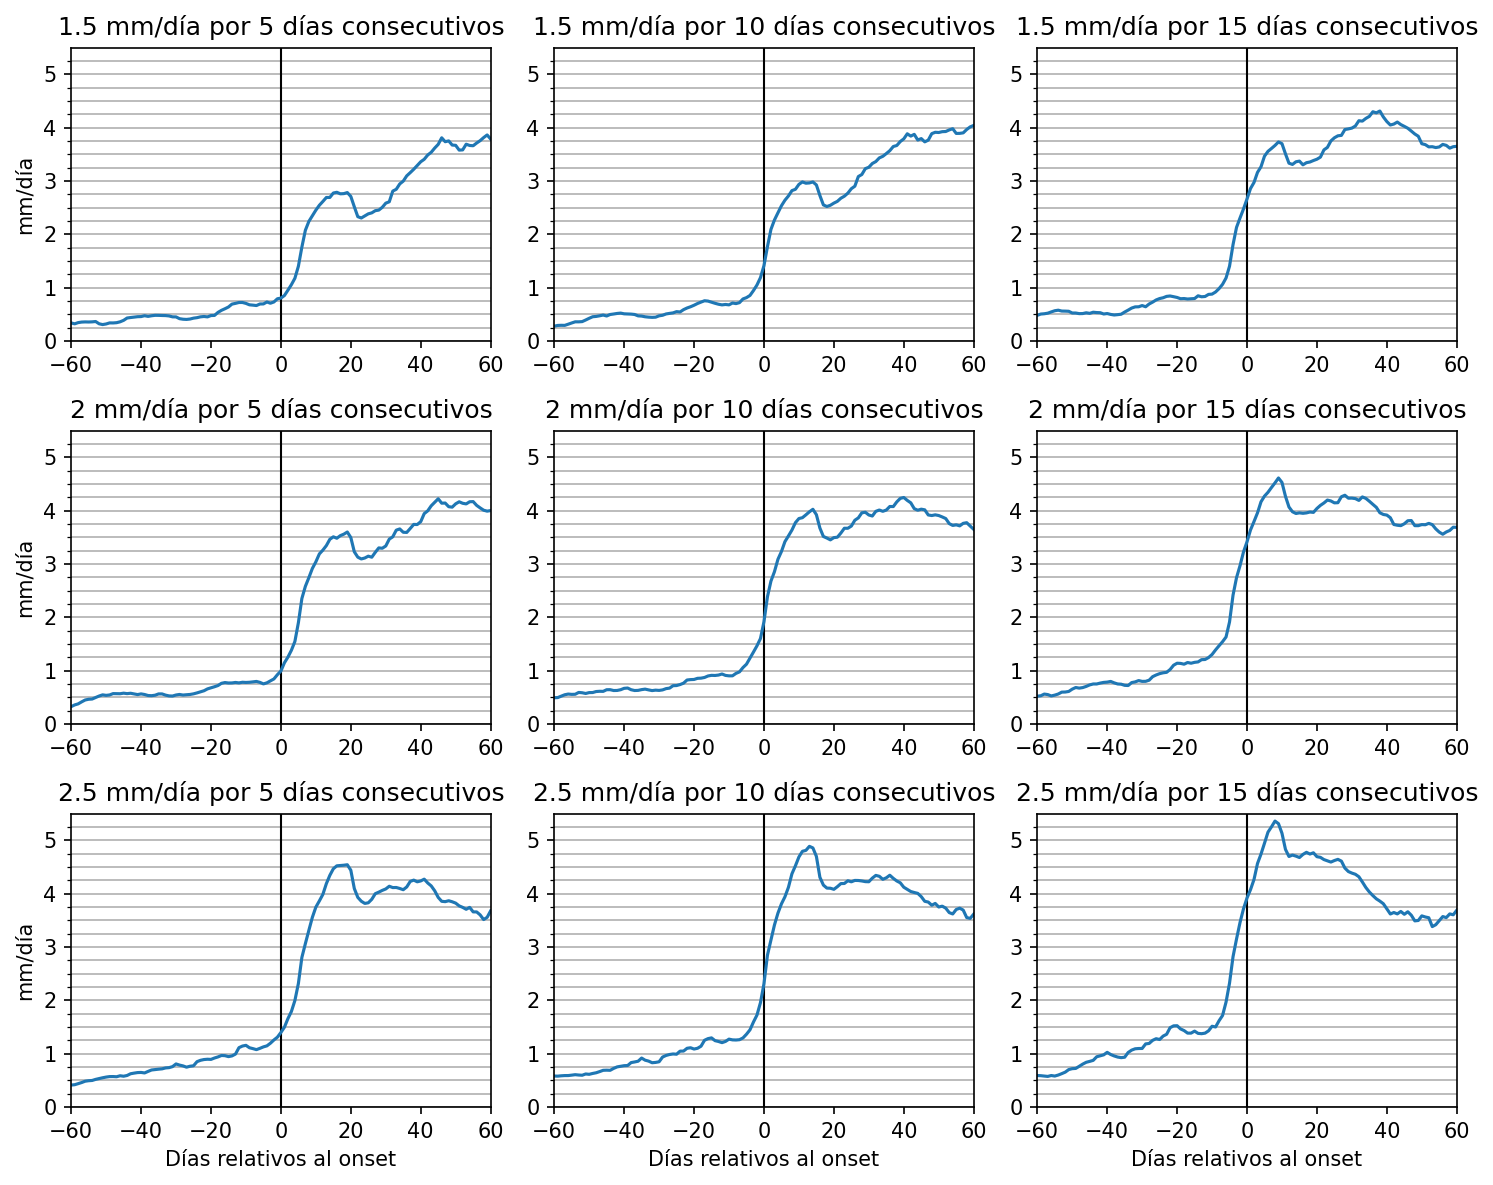

In [49]:
# Crea un índice de onset de acuerdo con
# el umbral para n días seguidos de
# cumplimiento con el criterio.
umbral = [1.5, 2, 2.5]
dias = [5, 10, 15]

# Mes inicial.
m_i = 4

lim = [5.5, 0.6]
step = [0.25, 0.05]
title = "onset_criteria_CPC.png"
fig_s = [None] #* 2
axes_s = [None] #* 2

for i in range( len(fig_s) ):
    # Ajustes de gráficas múltiples.
    fig_s[i], axes_s[i] = plt.subplots(len(umbral), len(dias))
    fig_s[i].set_facecolor("w")
    fig_s[i].set_size_inches(10, 8)
    fig_s[i].set_dpi(150)

for i_n, n in enumerate(dias):
    for i_u, u in enumerate(umbral):
        df_mean_ind = pd.DataFrame(
            df_mean.copy(), columns = ["Cuenca"] )

        c = "Cuenca"

        # Nombre de las columnas dummy.
        proc = [c]
        for i in range(0, n):
            proc.append(c +
                "_" + str(i)) 

        # Traslapa los últimos n días 
        # y da un valor de 1 a cada día 
        # que cumpla con el umbral.
        for i, p in enumerate(proc[1:]):
            df_mean_ind[p] = df_mean_ind[proc[0]].shift(i)
            df_mean_ind[p].clip( upper = u, inplace = True )
            df_mean_ind[p] = df_mean_ind[p].where( df_mean_ind[p] == u, 0 )
            df_mean_ind[p] = df_mean_ind[p].where( df_mean_ind[p] < u, 1 )

        # El índice es uno si los n
        # cumplen con el umbral.
        ind = "Index_" + c
        df_mean_ind[ind] = 0
        for i in range(n):
            df_mean_ind[ind] += df_mean_ind[proc[i + 1]]
        df_mean_ind[ind] = df_mean_ind[ind].where(df_mean_ind[ind] == n, 0)
        df_mean_ind[ind] = df_mean_ind[ind].where(df_mean_ind[ind] < n, 1)
        df_mean_ind.drop(proc[1:], axis = 1, inplace = True)

        # Crea una tabla con los valores anuales.
        col = []
        name = "Cuenca"
        col.append(name + " - Onset")
        col.append(name + " - Withdrawal")
        col.append(name + " - Length")

        date = pd.DataFrame()
        years = range(1981, 2021)

        for j in years:
            # Solo utilizamos valores entre mayo y diciembre.
            df_year = df_mean_ind[ (df_mean_ind.index.year == j)
                & df_mean_ind.index.month.isin(range(m_i, 12)) ]

            row = []

            # Fechas.
            row.append( df_year.iloc[:, 1].idxmax() )
            row.append( df_year.iloc[::-1, 1].idxmax() )
            row.append( df_year.iloc[::-1, 1].idxmax()
                - df_year.iloc[:, 1].idxmax() )

            # Agregamos la fila al DataFrame.
            date = date.append([row])

        # Damos formato a las columnas y al índice.
        date.columns = col
        date.index = years
        date.index.name = "Año"
        # Recorremos al inicio de la racha de días de precipitación.
        date.iloc[:, 0] = date.iloc[:, 0] - np.timedelta64(10, 'D')

        # Longitud de la temporada de lluvias.
        print(f"{u} mm/día, {n} días consecutivos, " +
            f"{date.iloc[:, 2].mean().days} días de duración")

        # Calculamos el shift necesario para alinear las fechas.
        shift = date.iloc[:, 0].apply(lambda x: x.dayofyear)
        delta = shift.max()
        shift = shift.max() - shift

        for i in range( len(fig_s) ):

            # Creamos un DataFrame con año
            # como columnas y días como filas.
            pre_df = pd.DataFrame(
                df_mean.copy(), columns = [ df_mean.columns[i] ] )
            pre_df["Año"] = pre_df.index.year
            pre_df["Día"] = pre_df.index.dayofyear

            # Ajustamos el dayofyear de años bisiestos.
            qty = int( pre_df[ pre_df.index.is_leap_year ].shape[0] / 365 )
            pre_df.loc[pre_df.index.is_leap_year, "Día"
                ] = list(range(1, 366)) * qty

            # Convertimos los años a columnas.
            pre_df = pre_df.pivot(index = "Día", columns = "Año")
            pre_df.columns = pre_df.columns.droplevel(0)

            # Alineamos las series de tiempo.
            for j in pre_df.columns:
                pre_df[j] = pre_df[j].shift(shift[j])

            # Promediamos y seleccionamos 120 días.
            pre_df = pre_df.mean(axis = 1)
            pre_df = pre_df.loc[delta - 60: delta + 60]
            pre_df.index = range(-60, 61)

            # Graficamos.
            axes_s[i][i_u, i_n].plot( (0, 0), ( 0, lim[i] ), color = "k",
                linewidth = 1 )
            pre_df.plot(ax = axes_s[i][i_u, i_n])

            axes_s[i][i_u, i_n].set_title(
                f"{u} mm/día por {n} días consecutivos")
            axes_s[i][i_u, i_n].set_xlim(-60, 60)
            axes_s[i][i_u, i_n].set_ylim(0, lim[i])

            if i_n == 0: 
                axes_s[i][i_u, i_n].set_ylabel("mm/día")
            if i_u == 2: 
                axes_s[i][i_u, i_n].set_xlabel("Días relativos al onset")

            for ax in axes_s[i].flatten():
                ax.set_yticks( np.arange(0, lim[i], step[i]), minor = True )
                ax.grid( visible = True, which = "both", axis ="y" )

            # Separación adecuada entre gráficas.
            fig_s[i].tight_layout()

            # Guardamos el archivo.
            #fig_s[i].savefig( path_d + title )

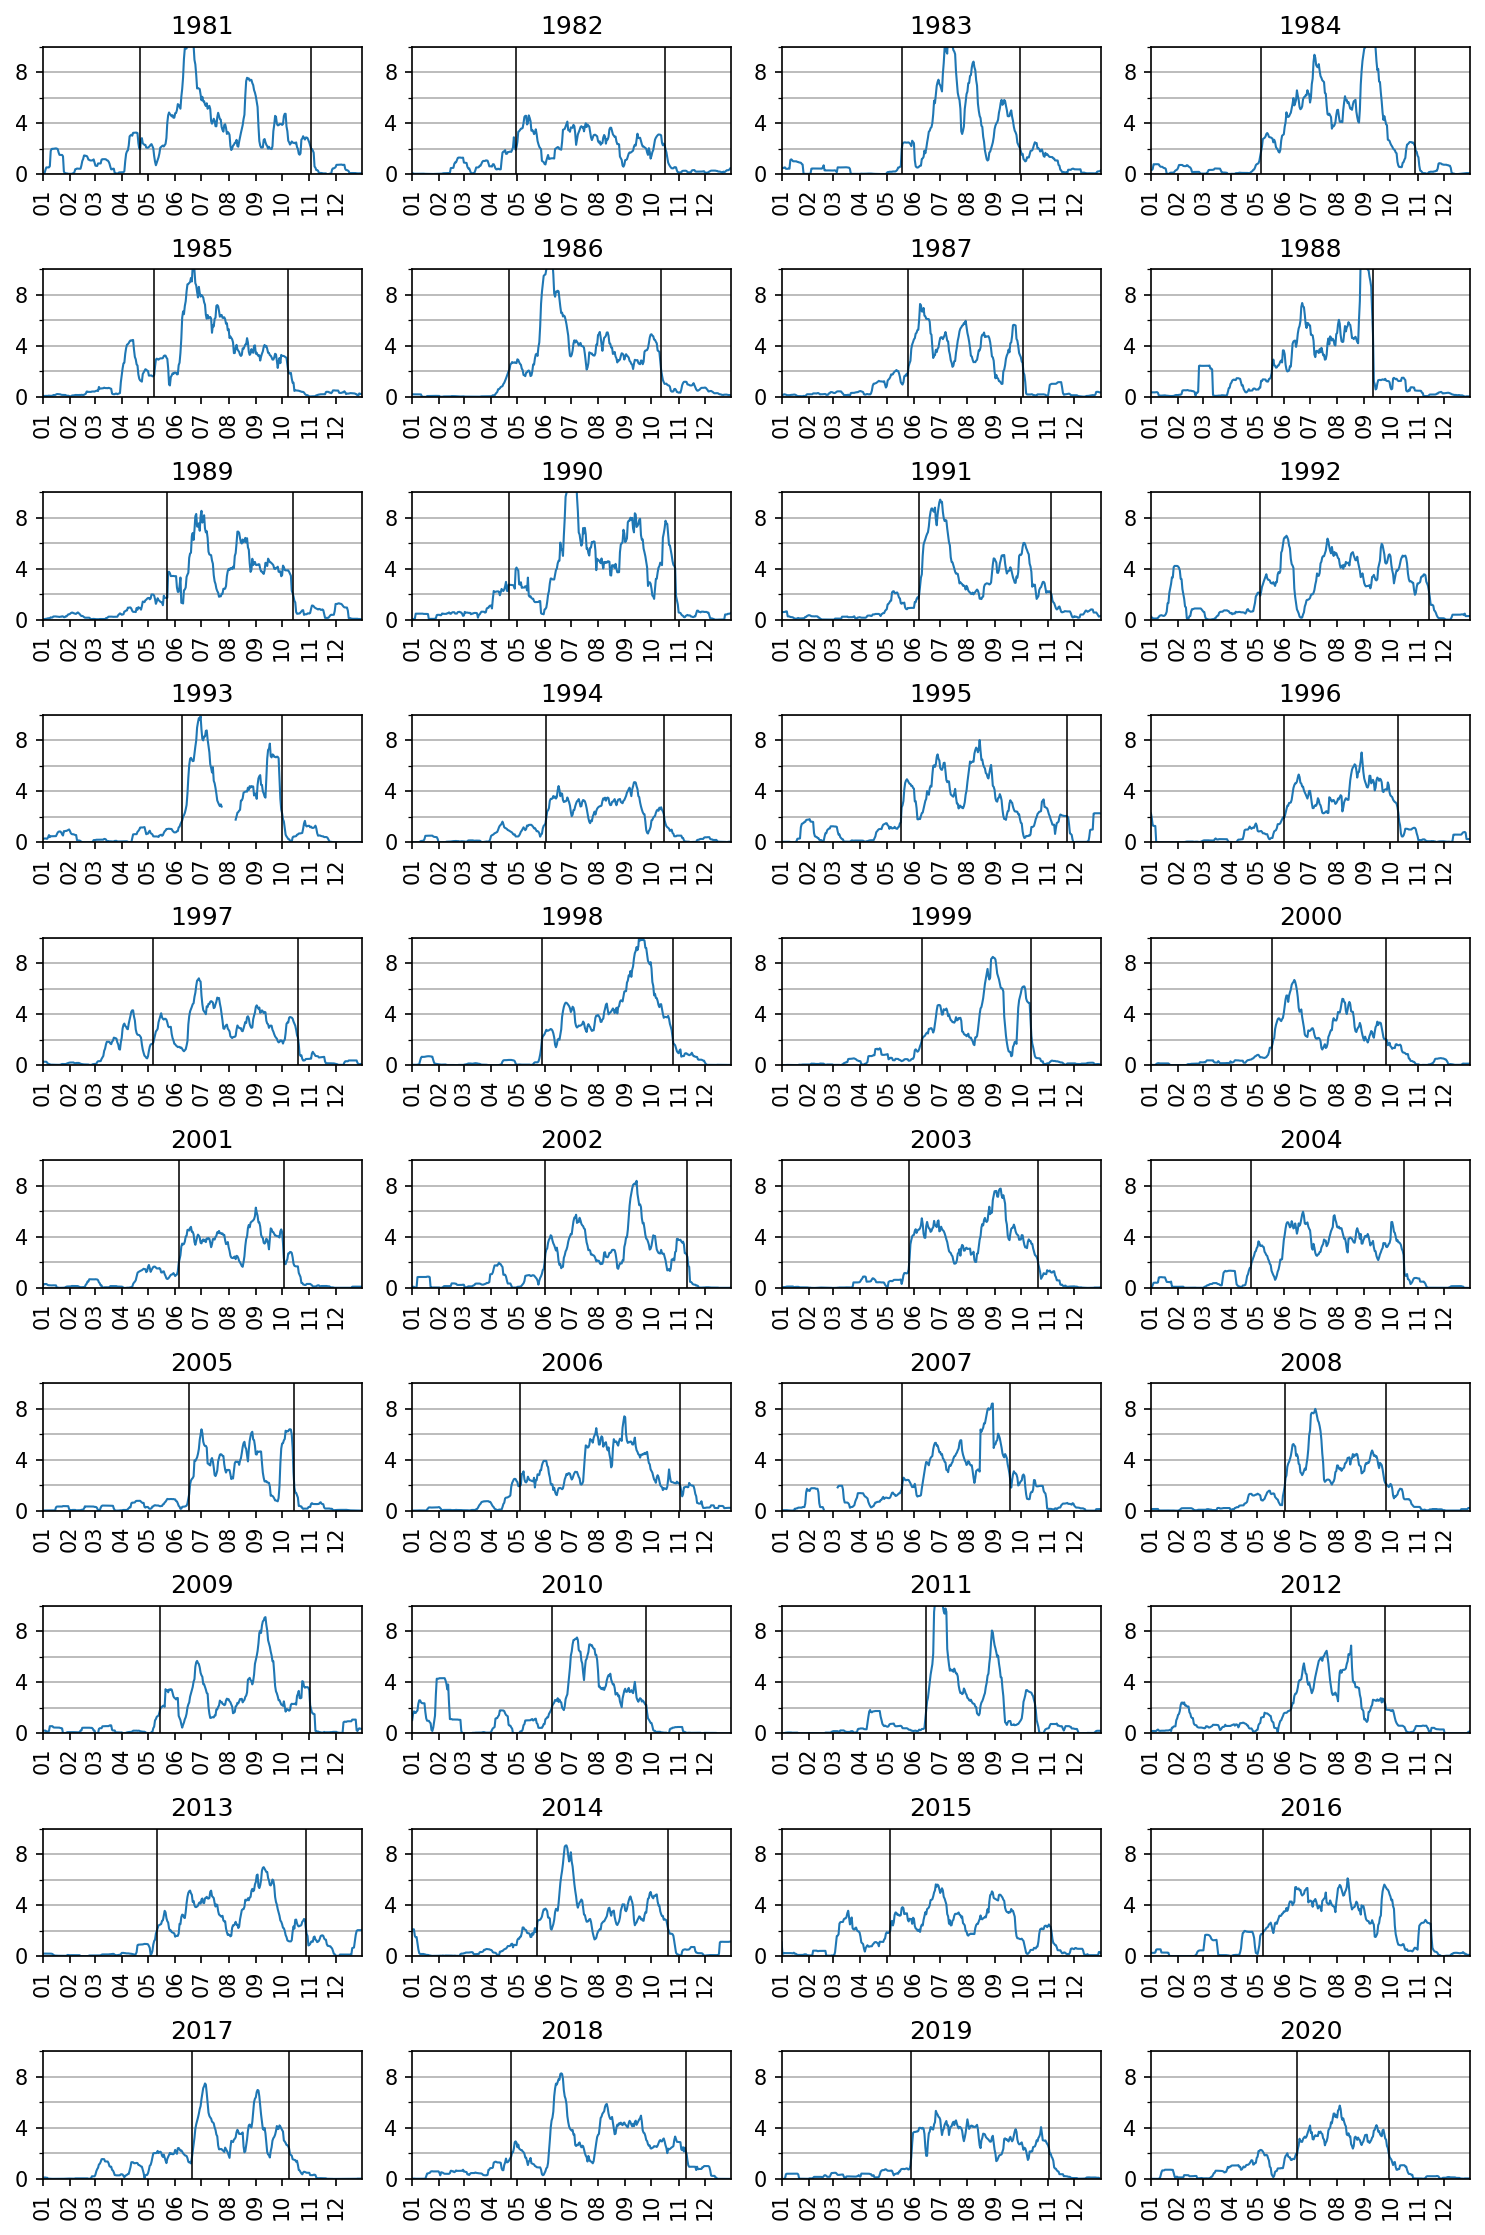

In [ ]:
# Crea un índice de onset de acuerdo con
# el umbral para n días seguidos de
# cumplimiento con el criterio.
umbral = 2
n = 10

# Mes inicial
m_i = 4

df_mean_ind = pd.DataFrame(
    df_mean.copy(), columns = ["Cuenca"] )

c = "Cuenca"

# Nombre de las columnas dummy.
proc = [c]
for i in range(0, n):
    proc.append(c + "_" + str(i)) 

# Traslapa los últimos 3 días 
# y da un valor de 1 a cada día 
# que cumpla con el umbral.
for i, p in enumerate(proc[1:]):
    df_mean_ind[p] = df_mean_ind[proc[0]].shift(i)
    df_mean_ind[p].clip( upper = umbral,
        inplace = True )
    df_mean_ind[p] = df_mean_ind[p].where(
        df_mean_ind[p] == umbral, 0)
    df_mean_ind[p] = df_mean_ind[p].where(
        df_mean_ind[p] < umbral, 1)

# El índice es uno si los n
# cumplen con el umbral.
ind = "Index_" + c
df_mean_ind[ind] = 0
for i in range(n):
    df_mean_ind[ind] += df_mean_ind[proc[i + 1]]
df_mean_ind[ind] = df_mean_ind[ ind
    ].where(df_mean_ind[ind] == n, 0)
df_mean_ind[ind] = df_mean_ind[ ind
    ].where(df_mean_ind[ind] < n, 1)
df_mean_ind[ind] = df_mean_ind[ ind
    ].where( df_mean_ind.index.month.isin(
    range(5, 12) ), 0 )
df_mean_ind.drop(proc[1:],
    axis = 1, inplace = True)

# Crea una tabla con los valores anuales.
col = []
name = "Cuenca"
col.append(name + " - Onset")
col.append(name + " - Withdrawal")
col.append(name + " - Length")

date = pd.DataFrame()
years = range(1981, 2021)

for j in years:
    # Solo utilizamos valores entre mayo y noviembre.
    df_year = df_mean_ind[ (df_mean_ind.index.year == j)
        & df_mean_ind.index.month.isin(range(m_i, 12)) ]

    row = []

    # Fechas.
    row.append( df_year.iloc[:, 1].idxmax() )
    row.append( df_year.iloc[::-1, 1].idxmax() )
    row.append( df_year.iloc[::-1, 1].idxmax()
        - df_year.iloc[:, 1].idxmax() )

    # Agregamos la fila al DataFrame.
    date = date.append([row])

# Damos formato a las columnas y al índice.
date.columns = col
date.index = years
date.index.name = "Año"
# Recorremos al inicio de la racha de días de precipitación.
date.iloc[:, 0] = date.iloc[:, 0] - np.timedelta64(10, 'D')

# Calculamos el shift necesario para alinear las fechas.
shift = date.iloc[:, 0].apply(lambda x: x.dayofyear)

# Guarda las series de tiempo.
date.to_csv(path_d + "onset_CPC.csv")
shift.to_csv(path_d + "shift_CPC.csv")

year = np.arange( 1981, 2021 )

#print(f"Onset     : {onset.day:02d}"
#    + f" {onset.month_name()}")
#print(f"Withdrawal: {withdrawal.day:02d}"
#    + f" {withdrawal.month_name()}")

# Graficamos.
fig, axes = plt.subplots(10, 4)
axes = axes.flatten()
fig.set_facecolor("w")
fig.set_size_inches(10, 15)
fig.set_dpi(150)

xtick_lab = [ f"{x:02d}" for x in range(1, 13) ]


for i in range( len(year) ):
    df_year = df_mean_ind[ df_mean_ind.index.year == year[i] ]

    # Fechas.
    onset = date.iloc[date.index == year[i], 0]
    withdrawal = date.iloc[date.index == year[i], 1]

    axes[i].plot(df_year.iloc[:, 0], linewidth = 1)
    #ax.plot(df_year.iloc[:, 1])

    # Onset y withdrawal.
    axes[i].plot( (onset, onset), (0, 12),
        color = "k", linewidth = 0.75 )
    axes[i].plot( (withdrawal, withdrawal), (0, 12), 
        color = "k", linewidth = 0.75 ) 

    axes[i].set_title(year[i])
    axes[i].set_yticks( range(0, 14, 4), minor = False )
    axes[i].set_yticks( range(0, 14, 2), minor = True)
    axes[i].grid(axis = "y", which = "both")
    #axes[0].set_ylabel("Precipitación diaria [mm]")
    #axes[0].set_xlabel("Tiempo")
    axes[i].set_ylim(0, 10)
    #axes[i].set_ylim(0, np.ceil(df_year.iloc[:, 0].max()) )
    axes[i].set_xlim( pd.to_datetime( str(year[i]) + "-01-01" ),
        pd.to_datetime( str(year[i]) + "-12-31") )
    # Formato de fecha.
    axes[i].xaxis.set_major_locator(mdates.MonthLocator())
    axes[i].xaxis.set_major_formatter(mdates.DateFormatter("%m"))
    axes[i].set_xticks( axes[i].get_xticks(), xtick_lab, rotation = 90 )

# Separación adecuada entre gráficas.
fig.tight_layout()